In [1]:
from scipy.io import wavfile
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from ripser import ripser
from persim import plot_diagrams
import tadasets
from itertools import combinations
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from numba import jit
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline

In [2]:
#Functions used
def SW_cloud(f, tau, d, n_data):
    x_vals = f[0]
    y_vals = f[1]
    cs = CubicSpline(x_vals, y_vals)
    t_vals = np.linspace(np.min(x_vals), np.max(x_vals)-tau, n_data)
    SW = np.zeros((n_data, d+1))
    for i, t in enumerate(t_vals):
        SW_f_t = cs(t + np.arange(0, d+1) * tau)
        SW[i] = SW_f_t
    return SW

def RestrictedCocycle(cocycle1,cocycle2):
    New_cocycle1=[]
    edges=[]
    for i in range(len(cocycle1)):
            for j in range(len(cocycle2)):
                if np.array_equal(cocycle1[i:i-1, :2], cocycle1[i:i+1, :2], cocycle2[j:j+1, :2]):  
                    New_cocycle1.append(cocycle2[j:j+1])
            New_cocycle1.append(cocycle2[i:i+1])        
    rcocycle1=np.vstack(New_cocycle1)
    for i in range(len(cocycle1)):
            for j in range(len(cocycle2)):
                if np.array_equal(cocycle1[i-1:i, :2], cocycle2[j:j+1, :2]):
                    edges.append(cocycle2[j:j+1])        
    if len(edges)!=0:
        edges=np.vstack(edges)
    else:
        edges=edges
    for i in range(len(rcocycle1)):
        found_match = False
        for j in range(len(edges)):
            if np.array_equal(rcocycle1[i, :2], edges[j, :2]):
                found_match = True
                break
        if not found_match:
            rcocycle1[i, -1] = 0
    rcocycle=rcocycle1         
    return rcocycle


def cupProduct(phi, psi, triangleList): #Compute Cup Product
    cupProduct = []
    for i in range(len(triangleList)):
        phiVal = 0
        psiVal = 0
        for j in range(len(phi)):
            if phi[j][0] == triangleList[i][0] and phi[j][1] == triangleList[i][1]:
                phiVal = phi[j][2]
                break;
        for k in range(len(psi)):
            if psi[k][0] == triangleList[i][1] and psi[k][1] == triangleList[i][2]:
                psiVal = psi[k][2]
                break;
        cupProduct.append(phiVal * psiVal)
    cupProduct = np.array(cupProduct).T
    return cupProduct

def reductionAlgorithm(R):
    numRows = len(R[0])
    V = np.eye(numRows)
    pivotRows, pivotEntries = [[] for i in range (numRows)], [[] for i in range (numRows)]
    for i in range(numRows):
        h = 0
        while (h == 0):
            pivotRow = np.inf
            for j in range(numRows - 1, -1, -1):
                if R[j][i] != 0:
                    pivotRow = j
                    break;
            if pivotRow == np.inf:
                pivotEntries[i] = 0
            else:
                pivotEntries[i] = R[pivotRow][i]
            pivotRows[i] = pivotRow
            if pivotRow == np.inf or all(pivotRows[k] != pivotRows[i] for k in range(i)):
                h = 1
                break;
            for k in range(i):
                if pivotRows[k] == pivotRows[i]:
                    c = pivotEntries[i] // pivotEntries[k]
                    for l in range(numRows):
                        R[l][i] -= c * R[l][k]
                        V[l][i] -= c * V[l][k]            
    return R

def checkSolution(A, b):
    # Calculate the rank of the augmented matrix [A | b]
    augmented_matrix = np.column_stack((A, b))
    rank_A = np.linalg.matrix_rank(A)
    rank_augmented = np.linalg.matrix_rank(augmented_matrix)
    num_columns = A.shape[1]
    num_rows = A.shape[0]
    if rank_A == rank_augmented:
        if rank_A == num_columns:
            return 1
        elif rank_A < num_columns:
            return 1
    else:
        if rank_A < rank_augmented:
            return 0
    return "Unable to determine the solution status."

def rowDetect(A, b):
    iMax = len(A) + 1
    iMin = 1
    i = len(A) // 2
    running = True
    while(running):
        sol = checkSolution(A[-i:], b[-i:])
        if sol == 0:
            if checkSolution(A[-(i - 1):], b[-(i - 1):]) == 1:
                row = len(A) - i
                running = False
                break;
            else:
                if i < iMax:
                    iMax = i
                    i = (iMax + iMin) // 2
        if sol == 1:
            if i > iMin:
                iMin = i
                i = (iMax + iMin) // 2
            if i==len(A):
                row=-1
                running=False
                break;
    return row+1

def rowTriangle(r):
    value=len(triangles)-1-r
    return triangles[value]

def find_prominent_peaks(magnitude_spectrum, threshold, prominence):
    # Find all peaks in the magnitude spectrum
    peaks, _ = find_peaks(magnitude_spectrum, height=threshold, prominence=prominence)
    sorted_peaks = sorted(peaks, key=lambda p: -magnitude_spectrum[p])
    cumulative_sum = np.cumsum(magnitude_spectrum[sorted_peaks])
    total_sum = np.sum(magnitude_spectrum[sorted_peaks])
    n_peaks = np.searchsorted(cumulative_sum, 0.9 * total_sum, side='right') #Subject to Change the amount
    return sorted_peaks[:n_peaks]

#Find the <k,w> values 
def find_prominent_freqs(magnitude_spectrum, sample_rate, threshold=0.1, prominence=0.1):
    # Find all peaks in the magnitude spectrum
    peaks, _ = find_peaks(magnitude_spectrum, height=threshold, prominence=prominence)
    # Sort the peaks by their prominence
    sorted_peaks = sorted(peaks, key=lambda p: -magnitude_spectrum[p])
    # Calculate the frequency bins
    freq_bins = np.fft.fftfreq(len(magnitude_spectrum), 1 / sample_rate)
    # Get the frequency values corresponding to the prominent peaks
    freq_values = freq_bins[sorted_peaks]
    return freq_values


def tauSum(tau,freq_values):
    tauSum = 0
    d=len(freq_values)
    for i in range(len(freq_values)):
        for j in range(i):
            reSum = 1
            imSum = 0
            for k in range(d + 1):
                reSum += np.cos((freq_values[i] - freq_values[j]) * tau * k)
                imSum += np.sin((freq_values[i] - freq_values[j]) * tau * k)
            tauSum += (reSum ** 2) + (imSum ** 2)
    return tauSum

def op_tau(pk,magnitude_spectrum,sample_rate, threshold, prominence):
    tauVals = np.linspace(0, np.pi, 10000)
    freq_values=find_prominent_freqs(magnitude_spectrum, sample_rate, threshold, prominence)
    minSum = 100000000000000000000
    bestTau = None
    for tau in tauVals:
        if tauSum(tau,freq_values) < minSum:
            minSum = tauSum(tau,freq_values)
            bestTau = tau    
    return(bestTau)

def segmentation(x_values):
    windows=[]
    window_size=int(len(x_values)/100)
    i=0
    while i < len(x_values):
        section=x_values[i:i+window_size]
        windows.append(section)
        i+=window_size
    return windows


def time_series(segment_matrix):
    time_series_matrix=[]
    for segment in segment_matrix:
        y_values=left_channel[segment]
        f=np.array([segment,y_values])
        time_series_matrix.append(f)
    return time_series_matrix
        
def op_dtau_matrix(time_series_matrix,sample_rate):
    opd=[]
    optau=[]
    for ts in time_series_matrix:
        x_v=ts[0]
        x_t=time[np.min(x_v):np.max(x_v)+1]
        x_t=np.array(x_t)
        timestamps = pd.to_datetime(x_t)
        timestamps = timestamps.strftime('%M:%S.%f')
        fs = pd.Series(ts[1], index=timestamps)
        dft = np.fft.fft(fs)
        n = len(dft)
        freqs = np.fft.fftfreq(n, 1/sample_rate)
        magnitude_spectrum = np.abs(dft)
        pk=find_prominent_peaks(magnitude_spectrum, 0.1, 0.1)
        t=op_tau(pk,magnitude_spectrum,sample_rate,0.1, 0.1)
        opd.append(len(pk))
        optau.append(t)
    return opd,optau
    
    
def SW_matrix(time_series_matrix,opd, optau):
    S_matrix=[]
    h=0
    for ts in time_series_matrix:
        SW=SW_cloud(ts,optau[h],opd[h],1000)
        S_matrix.append(SW)
        h+=1
    return S_matrix

def point_cloud_diameter(points):
    distances = pairwise_distances(points)
    max_distance = np.max(distances)
    return max_distance
              
def Q_Score(S_matrix): #Used for initial Q-Score detection
    q_score=[]
    for S in S_matrix:
        try:
            #Part 1: Get the Cup Product
            result = ripser(S, n_perm=200,coeff=2, do_cocycles=True)
            diagrams = result['dgms']
            cocycles = result['cocycles'] #all of the cocycles
            D = result['dperm2all'] #distance matrix between the ith and jth points in the data
            dgm1 = diagrams[1]
            #Representative cocycle phi
            idx1 = np.argmax(dgm1[:, 1] - dgm1[:, 0])
            cocycle1 = cocycles[1][idx1]
            #Representative cocycle psi
            sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
            idx2 = sorted_indices[-2]
            cocycle2 = cocycles[1][idx2]
            rcocycle=RestrictedCocycle(cocycle1,cocycle2)
            representative_cocycles = []
            for i in range(len(dgm1)):
                birth, death = dgm1[i]
                if birth != death:  # ignore points on the diagonal
                    cocycle = cocycles[1][i]
                    representative_cocycles.append(cocycle)
            triangles = []
            for cocycle in representative_cocycles:
                edge_indices = cocycle[:, :2].astype(int)
                triangle_vertices = set()
                for i, j in edge_indices:
                    triangle_vertices.add(i)
                    triangle_vertices.add(j)
                triangle_combinations = combinations(triangle_vertices, 3)
                for combination in triangle_combinations:
                    triangles.append(list(combination))
            t=np.vstack(triangles)
            if len(cocycle1) >= len(cocycle2):
                cup=cupProduct(rcocycle,cocycle2, t)#Compute the cup Product
            else:
                cup=cupProduct(rcocycle,cocycle1, t)
            cup=np.vstack(cup)
            edges = []
            vertices=[]
            representative_cocycles = []
            for i in range(len(dgm1)):
                birth, death = dgm1[i]
                if birth != death:  
                    cocycle = cocycles[1][i]
                    representative_cocycles.append(cocycle)
            for cocycle in representative_cocycles: # Extracting every edge as an array of vertices
                edge_indices = cocycle[:, :2].astype(int)
                for i, j in edge_indices:
                    edge = [i, j]
                    edges.append(edge)
            for cocycle in representative_cocycles: #Extracting every vertex
                vertex_indices = cocycle[:, :1].astype(int)
                for i in vertex_indices:
                    vertices.append(i[0])
            vertices = list(set(vertices)) # Remove duplicate vertices by converting the list to a set and then back to a list
            ne = len(edges)
            nt = len(triangles)
            nv = len(vertices)
            num_rows= ne+nt+nv
            num_cols=ne+nt+nv
            boundary_matrix=np.zeros((num_rows, num_cols), dtype=int)
            for i,edge in enumerate(edges):
                a,b=edge #a and b are the two verticies that make up the edge
                for j,vertex in enumerate(vertices):
                    c=vertex # c is a vertex
                    if b == c:
                        boundary_matrix[nv+i,j]=1
                    if a == c:
                        boundary_matrix[nv+i,j]=-1
            for i, triangle in enumerate(triangles):
                e,f,g=triangle #e,f,g are verticies in the triangle
                for j,edge in enumerate(edges):
                    h,k=edge 
                    if (h,k) == (e,f):
                        boundary_matrix[(ne+nv)+i,nv+j]=1
                    if (h,k) == (f,g):
                        boundary_matrix[(ne+nv)+i,nv+j]=1
                    if (h,k) == (e,g):
                        boundary_matrix[(ne+nv)+i,nv+j]=-1
            boundary_matrix=boundary_matrix.T
            #Convert Boundary Matrix into Coboundary
            restricted_matrix = boundary_matrix[nv:nv + ne, nv + ne:len(boundary_matrix)]
            coboundary_matrix = np.flip(restricted_matrix).T
            reduce=reductionAlgorithm(coboundary_matrix)
            detect=rowDetect(reduce, cup)
            tri=rowTriangle(detect)
            sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
            idx2 = sorted_indices[-2]
            h = max(dgm1[idx1, 0], dgm1[idx2, 0])
            while h < min(dgm1[idx1, 1], dgm1[idx2, 1])+100000:
                newRun = ripser(S, n_perm=200, coeff=2, thresh = h, do_cocycles = True)
                newDiagrams = newRun['dgms']
                newCocycles = newRun['cocycles']
                D = newRun['dperm2all']
                dgmNew = newDiagrams[1]
                new_representative_cocycles = []
                for i in range(len(dgmNew)):
                    birth, death = dgmNew[i]
                    if birth != death:  # ignore points on the diagonal
                        newCocycle = newCocycles[1][i]
                        new_representative_cocycles.append(newCocycle)
                newTriangles = []
                for newCocycle in new_representative_cocycles:
                    edge_indices = newCocycle[:, :2].astype(int)
                    new_triangle_vertices = set()
                    for i, j in edge_indices:
                        new_triangle_vertices.add(i)
                        new_triangle_vertices.add(j)
                    new_triangle_combinations = combinations(new_triangle_vertices, 3)
                    for combination in new_triangle_combinations:
                        newTriangles.append(list(combination))
                if len(newTriangles) !=0:
                     t=np.vstack(newTriangles)
                for k in range(len(t)):
                    if t[k][0] == tri[0] and t[k][1] == tri[1] and t[k][2] == tri[2]:
                        death=h #Gives the Cohomological death 
                        h = 1000000
                        break;
                h += 0.01
            #Part 4: Plot the persistence diagram with the new point
            birth=dgm1[idx2,1] #death of psi but birth of H2 point 
            QPDS = ((birth - death) * 9) / point_cloud_diameter(x)
            print("Quasiperiodicity Score: " + str(QPDS * 100) + "%")
            q_score.append(QPDS)  
            print(QPDS)
        except:
            QPDS=0
            q_score.append(QPDS)
    return q_score   


def Q_Score_Check(S_matrix): #This one is used for all 
    q_score=[]
    a=0
    for S in S_matrix:
        try:
            #Part 1: Get the Cup Product
            result = ripser(S, n_perm=200,coeff=2, do_cocycles=True)
            diagrams = result['dgms']
            cocycles = result['cocycles'] #all of the cocycles
            D = result['dperm2all'] #distance matrix between the ith and jth points in the data
            dgm1 = diagrams[1]
            #Representative cocycle phi
            idx1 = np.argmax(dgm1[:, 1] - dgm1[:, 0])
            cocycle1 = cocycles[1][idx1]
            #Representative cocycle psi
            sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
            idx2 = sorted_indices[-2]
            cocycle2 = cocycles[1][idx2]
            rcocycle=RestrictedCocycle(cocycle1,cocycle2)
            representative_cocycles = []
            for i in range(len(dgm1)):
                birth, death = dgm1[i]
                if birth != death:  # ignore points on the diagonal
                    cocycle = cocycles[1][i]
                    representative_cocycles.append(cocycle)
            triangles = []
            for cocycle in representative_cocycles:
                edge_indices = cocycle[:, :2].astype(int)
                triangle_vertices = set()
                for i, j in edge_indices:
                    triangle_vertices.add(i)
                    triangle_vertices.add(j)
                triangle_combinations = combinations(triangle_vertices, 3)
                for combination in triangle_combinations:
                    triangles.append(list(combination))
            t=np.vstack(triangles)
            if len(cocycle1) >= len(cocycle2):
                cup=cupProduct(rcocycle,cocycle2, t)#Compute the cup Product
            else:
                cup=cupProduct(rcocycle,cocycle1, t)
            cup=np.vstack(cup)
            edges = []
            vertices=[]
            representative_cocycles = []
            for i in range(len(dgm1)):
                birth, death = dgm1[i]
                if birth != death:  
                    cocycle = cocycles[1][i]
                    representative_cocycles.append(cocycle)
            for cocycle in representative_cocycles: # Extracting every edge as an array of vertices
                edge_indices = cocycle[:, :2].astype(int)
                for i, j in edge_indices:
                    edge = [i, j]
                    edges.append(edge)
            for cocycle in representative_cocycles: #Extracting every vertex
                vertex_indices = cocycle[:, :1].astype(int)
                for i in vertex_indices:
                    vertices.append(i[0])
            vertices = list(set(vertices)) # Remove duplicate vertices by converting the list to a set and then back to a list
            ne = len(edges)
            nt = len(triangles)
            nv = len(vertices)
            num_rows= ne+nt+nv
            num_cols=ne+nt+nv
            boundary_matrix=np.zeros((num_rows, num_cols), dtype=int)
            for i,edge in enumerate(edges):
                a,b=edge #a and b are the two verticies that make up the edge
                for j,vertex in enumerate(vertices):
                    c=vertex # c is a vertex
                    if b == c:
                        boundary_matrix[nv+i,j]=1
                    if a == c:
                        boundary_matrix[nv+i,j]=-1
            for i, triangle in enumerate(triangles):
                e,f,g=triangle #e,f,g are verticies in the triangle
                for j,edge in enumerate(edges):
                    h,k=edge 
                    if (h,k) == (e,f):
                        boundary_matrix[(ne+nv)+i,nv+j]=1
                    if (h,k) == (f,g):
                        boundary_matrix[(ne+nv)+i,nv+j]=1
                    if (h,k) == (e,g):
                        boundary_matrix[(ne+nv)+i,nv+j]=-1
            boundary_matrix=boundary_matrix.T
            #Convert Boundary Matrix into Coboundary
            restricted_matrix = boundary_matrix[nv:nv + ne, nv + ne:len(boundary_matrix)]
            coboundary_matrix = np.flip(restricted_matrix).T
            reduce=reductionAlgorithm(coboundary_matrix)
            detect=rowDetect(reduce, cup)
            tri=rowTriangle(detect)
            sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
            idx2 = sorted_indices[-2]
            h = max(dgm1[idx1, 0], dgm1[idx2, 0])
            while h < min(dgm1[idx1, 1], dgm1[idx2, 1])+100000:
                newRun = ripser(S, n_perm=200, coeff=2, thresh = h, do_cocycles = True)
                newDiagrams = newRun['dgms']
                newCocycles = newRun['cocycles']
                D = newRun['dperm2all']
                dgmNew = newDiagrams[1]
                new_representative_cocycles = []
                for i in range(len(dgmNew)):
                    birth, death = dgmNew[i]
                    if birth != death:  # ignore points on the diagonal
                        newCocycle = newCocycles[1][i]
                        new_representative_cocycles.append(newCocycle)
                newTriangles = []
                for newCocycle in new_representative_cocycles:
                    edge_indices = newCocycle[:, :2].astype(int)
                    new_triangle_vertices = set()
                    for i, j in edge_indices:
                        new_triangle_vertices.add(i)
                        new_triangle_vertices.add(j)
                    new_triangle_combinations = combinations(new_triangle_vertices, 3)
                    for combination in new_triangle_combinations:
                        newTriangles.append(list(combination))
                if len(newTriangles) !=0:
                     t=np.vstack(newTriangles)
                for k in range(len(t)):
                    if t[k][0] == tri[0] and t[k][1] == tri[1] and t[k][2] == tri[2]:
                        death=h #Gives the Cohomological death 
                        h = 1000000
                        break;
                h += 0.01
            #Part 4: Plot the persistence diagram with the new point
            birth=dgm1[idx2,1] #death of psi but birth of H2 point 
            QPDS = ((birth - death) * 9) / point_cloud_diameter(x)
            print("Quasiperiodicity Score: " + str(QPDS * 100) + "%")
            q_score.append()
            a+=1
        except:
            print(f'Window at Index: {a} does not Work') 
            a+=1
    return q_score  
    



In [3]:
#Take care of dealing with stupid audio data
file_path = 'tritone_example 4.wav'
sample_rate, audio_data = wavfile.read(file_path)
if audio_data.ndim == 2:
    left_channel = audio_data[:, 0]
    right_channel = audio_data[:, 1]
duration = len(audio_data) / sample_rate
time = np.arange(0, duration, 1 / sample_rate)
time=np.array(time)
timestamps = pd.to_datetime(time*1000000000)
timestamps = timestamps.strftime('%M:%S.%f')
time_series_1 = pd.Series(left_channel, index=timestamps)
time_series_2 = pd.Series(right_channel, index=timestamps)
print("Time Series Left Channel:")
print(time_series_1)
print("Time Series Right Channel:")
print(time_series_2)

Time Series Left Channel:
00:00.000000     6886
00:00.000022     5827
00:00.000045     4768
00:00.000068     3725
00:00.000090     2714
                ...  
00:00.460816    15780
00:00.460839    15110
00:00.460861    14305
00:00.460884    13377
00:00.460907    12327
Length: 20327, dtype: int16
Time Series Right Channel:
00:00.000000     6886
00:00.000022     5827
00:00.000045     4768
00:00.000068     3725
00:00.000090     2714
                ...  
00:00.460816    15780
00:00.460839    15110
00:00.460861    14305
00:00.460884    13377
00:00.460907    12327
Length: 20327, dtype: int16


/var/folders/40/zmgqdh5124d3j5h3bdpln8m80000gn/T/ipykernel_58481/1696110053.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(file_path)


Text(0.5, 1.0, 'Left Channel Data')

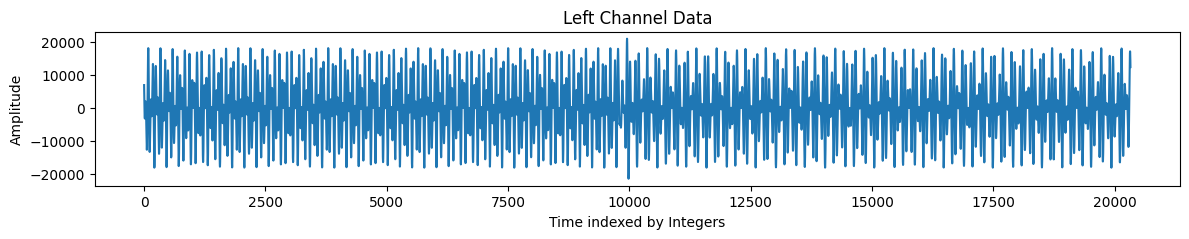

In [4]:
x_vals=time
x_values=x_vals = list(range(len(time)))
x_values = np.array(x_values)  
y_vals=left_channel
f=np.array([x_vals,y_vals])
plt.figure(figsize=(14, 2))
plt.plot(x_values, y_vals)
#plt.plot(f)
plt.xlabel('Time indexed by Integers')
plt.ylabel('Amplitude')
plt.title('Left Channel Data')

In [ ]:
#First Iteration
windows=segmentation(x_values)
time_series_matrix=time_series(windows)
opd,optau=op_dtau_matrix(time_series_matrix,sample_rate)
S_matrix=SW_matrix(time_series_matrix,opd,optau)
q_score=Q_Score(S_matrix)
if len(q_score)==0:
    print("No QuasiPeriodic Windows Detected")
potential_segments=[]
for score,i in q_score:
    if score>0.95:
        potential_segments.append(windows[i])
plt.figure(figsize=(14, 2))
plt.plot(x_values, y_vals,color='blue', label='Original Data')
plt.plot(np.min(potential_segments[0]),np.max(potential_segments[0]),color='red', label='Detected Window')
plt.xlabel('Time indexed by Integers')
plt.ylabel('Amplitude')
plt.title('Left Channel Data')



In [ ]:
#Verify Peristsnce Diagram and Perisist Cup Product


In [ ]:
#PCA 

#Input Sliding Window of Whatever you want to confirm
pca = PCA(n_components=3)
SW_pca = pca.fit(SW).transform(SW)

print('Explained Variance', pca.explained_variance_ratio_)

fig = go.Figure(data=[go.Scatter3d(
    x=SW_pca[:,0], y=SW_pca[:,1], z=SW_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 1.5, color = 'red')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()

In [ ]:
#Other iterations if needed
other_segments=[]
for segment in potential_segments:
    windows=segmentation(segment)
    time_series_matrix=time_series(windows)
    opdtau=op_dtau_matrix(time_series_matrix)
    S_matrix=SW_matrix(time_series_matrix,opdtau)
    q_score=Q_Score_Check(S_matrix)
    if len(q_score)==0:
        print("No QuasiPeriodic Windows Detected")
    for score,i in q_score:
        if score>0.95:
            other_segments.append(windows[i])